In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import hmp
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

In [3]:
import xarray as xr
import os
from pathlib import Path
DATA_PATH = Path(os.getenv("DATA_PATH"))
# data_paths = [DATA_PATH / "sat2/stage_data_proba_250hz.nc"]
data_paths = [str(DATA_PATH / "sat2/preprocessed_500hz/S1_epo.fif")]


In [4]:
from hmpai.visualization import set_seaborn_style
set_seaborn_style()

In [ ]:
# sfreq = 250  # For resampling

eeg_path = DATA_PATH / "sat2/preprocessed_500hz/"
subj_names = [
    x.split("_")[0] for x in os.listdir(eeg_path)
]  # in x and 'S14' not in x] #pbm with
subj_names = [subj for subj in subj_names]
subj_names.sort()
# subj_names = ['S11', 'S9', 'S10']
subj_names = [subj for subj in subj_names if subj in ['S1']]
subj_files = [str(eeg_path) + "/" + x + "_epo.fif" for x in subj_names]
epoch_data = hmp.utils.read_mne_data(
    subj_files,
    epoched=True,
    rt_col="rt",
    scale=1,
    lower_limit_RT=0.1,
    # upper_limit_RT=2.5,
    reject_threshold=1e-4,
    high_pass=1,
    verbose=False,
    subj_idx=subj_names,
    offset_after_resp=0.25,
    offset_before_stim=0.25,
    drop_force=True,
)
# Change epoch_data.offset to 0.05 seconds (12 samples), and add epoch_data.extra_offset with remainder
tmp_offset = epoch_data.offset
epoch_data = epoch_data.assign_attrs({'offset': 0, 'extra_offset': tmp_offset - 0})


In [17]:
epoch_data

<xarray.Dataset> Size: 1GB
Dimensions:      (participant: 1, epochs: 2322, channels: 64, samples: 1156)
Coordinates: (12/13)
  * epochs       (epochs) int64 19kB 0 1 2 3 4 5 ... 2371 2372 2373 2374 2375
  * channels     (channels) <U3 768B 'Fp1' 'AF7' 'AF3' 'F1' ... 'PO8' 'PO4' 'O2'
  * samples      (samples) int64 9kB 0 1 2 3 4 5 ... 1151 1152 1153 1154 1155
    event_name   (epochs) object 19kB 'stim/low/speed/right/3' ... 'stim/high...
    rt           (epochs) float64 19kB 0.468 0.408 0.444 ... 0.604 0.498 1.086
    stimulus     (epochs) object 19kB 'low/speed/right/3' ... 'high/accuracy/...
    ...           ...
    prefix       (epochs) object 19kB 'stim' 'stim' 'stim' ... 'stim' 'stim'
    force        (epochs) object 19kB 'low' 'low' 'low' ... 'high' 'high' 'high'
    condition    (epochs) object 19kB 'speed' 'speed' ... 'accuracy' 'accuracy'
    side         (epochs) object 19kB 'right' 'right' 'left' ... 'right' 'left'
    contrast     (epochs) object 19kB '3' '1' '2' '2' '2' ... '2' '1' '1' '2'
  * participant  (participant) <U2 8B 'S1'
Data variables:
    data         (participant, epochs, channels, samples) float64 1GB 8.134e-...
Attributes:
    sfreq:           500.0
    offset:          0
    offset_before:   125
    lowpass:         50.0
    highpass:        1.0
    lower_limit_RT:  0.1
    upper_limit_RT:  3.752
    extra_offset:    125

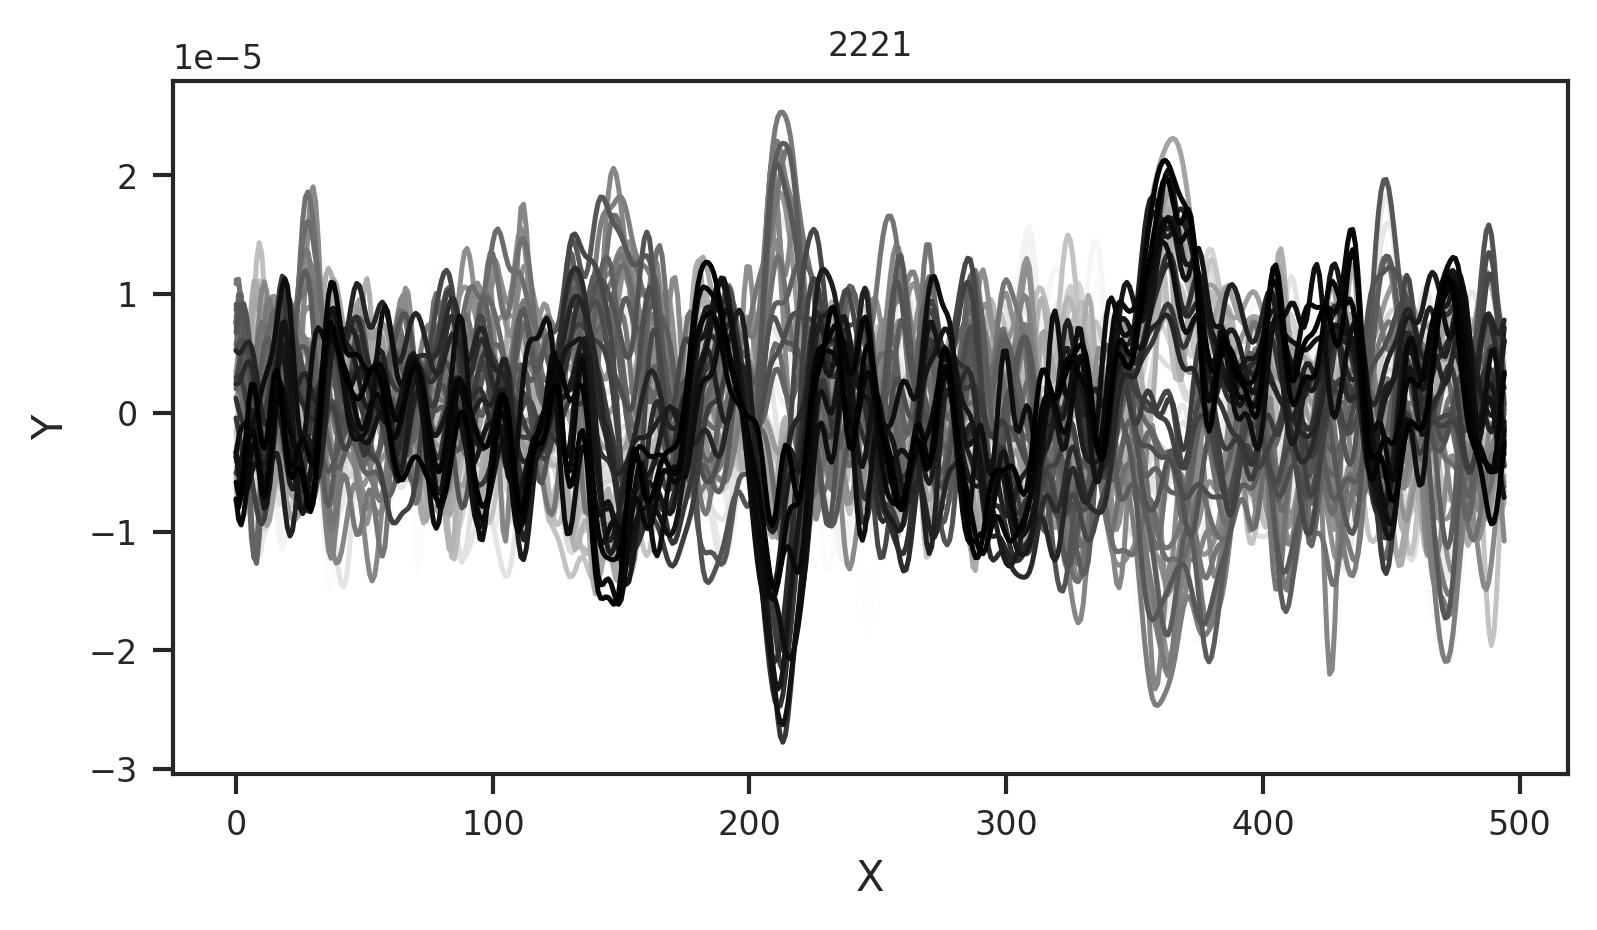

In [61]:
import pandas as pd
def plot_eeg(epoch):
    data = epoch_data.isel(participant=0, epochs=epoch).data
    data_long = pd.DataFrame(data).melt(var_name="X", value_name="Y", ignore_index=False)
    data_long.reset_index(inplace=True)
    data_long.rename(columns={"index": "channel"}, inplace=True)
    plt.figure(figsize=(6, 3), dpi=300)  # Adjust the figure size as needed
    sns.lineplot(data=data_long, x="X", y="Y", hue="channel", legend=False, palette=sns.color_palette('Greys', as_cmap=True))
    plt.title(epoch)
    plt.savefig("../img/eeg.svg")
    plt.show()
plot_eeg(2221) #7

In [ ]:
for i in [2221, 1471, 315]:
    plot_eeg(i)

In [ ]:
import random
# 2221, 1471, 315
for i in [random.randint(0, len(epoch_data.epochs)) for _ in range(0, 10)]:
    plot_eeg(i)

#### Density

In [27]:
from hmpai.pytorch.normalization import *
from hmpai.data import SAT1_STAGES_ACCURACY, SAT_CLASSES_ACCURACY
from hmpai.pytorch.generators import MultiXArrayProbaDataset
data_paths = [DATA_PATH / "sat2/stage_data_proba_250hz.nc"]
train_data = MultiXArrayProbaDataset(
    data_paths,
    # participants_to_keep=['S1'],
    normalization_fn=norm_dummy,
    whole_epoch=True,
    labels=SAT_CLASSES_ACCURACY,
    info_to_keep=['event_name'],
    # subset_cond=subset_cond,
    skip_samples=62,
    cut_samples=63,
    # add_negative=add_negative,
    norm_vars=(None, None),
)

In [28]:
from torch.utils.data import DataLoader

loader = DataLoader(
    train_data, batch_size=128, shuffle=True, num_workers=0, pin_memory=True
)

In [31]:
from hmpai.utilities import MASKING_VALUE, get_masking_index, get_masking_indices
def plot_density_hmp(loader, labels=SAT_CLASSES_ACCURACY):
    target_length = 1000

    probas = torch.zeros((target_length, len(labels)))
    speed_cnt = 0
    acc_cnt = 0
    plt.figure(figsize=(9, 5), dpi=300)
    for batch in loader:
        lengths = get_masking_indices(batch[0])
        true = batch[1]
        info = batch[2][0]

        for i in range(true.shape[0]):
            is_speed = "speed" in info["event_name"][i]
            true_epoch = true[i, :lengths[i]].permute(1, 0).unsqueeze(0)
            true_normalized = torch.nn.functional.interpolate(true_epoch, size=target_length, mode="linear", align_corners=False)
            # true_normalized = true_normalized / true_normalized.sum(dim=2, keepdim=True)
            true_normalized = true_normalized.squeeze().permute(1, 0)
            probas += true_normalized
            speed_cnt += is_speed
            acc_cnt += not is_speed
    
    probas /= acc_cnt + speed_cnt
    # Adjust confirmation for amt of speed trials
    # probas[:, -2] *= (acc_cnt + speed_cnt) / speed_cnt


    for i, label in enumerate(labels):
        if i == 0: continue

        sns.lineplot(probas[:, i], label=label, color=sns.color_palette()[i])
    plt.savefig("../img/density_hmp.svg")
    plt.show()


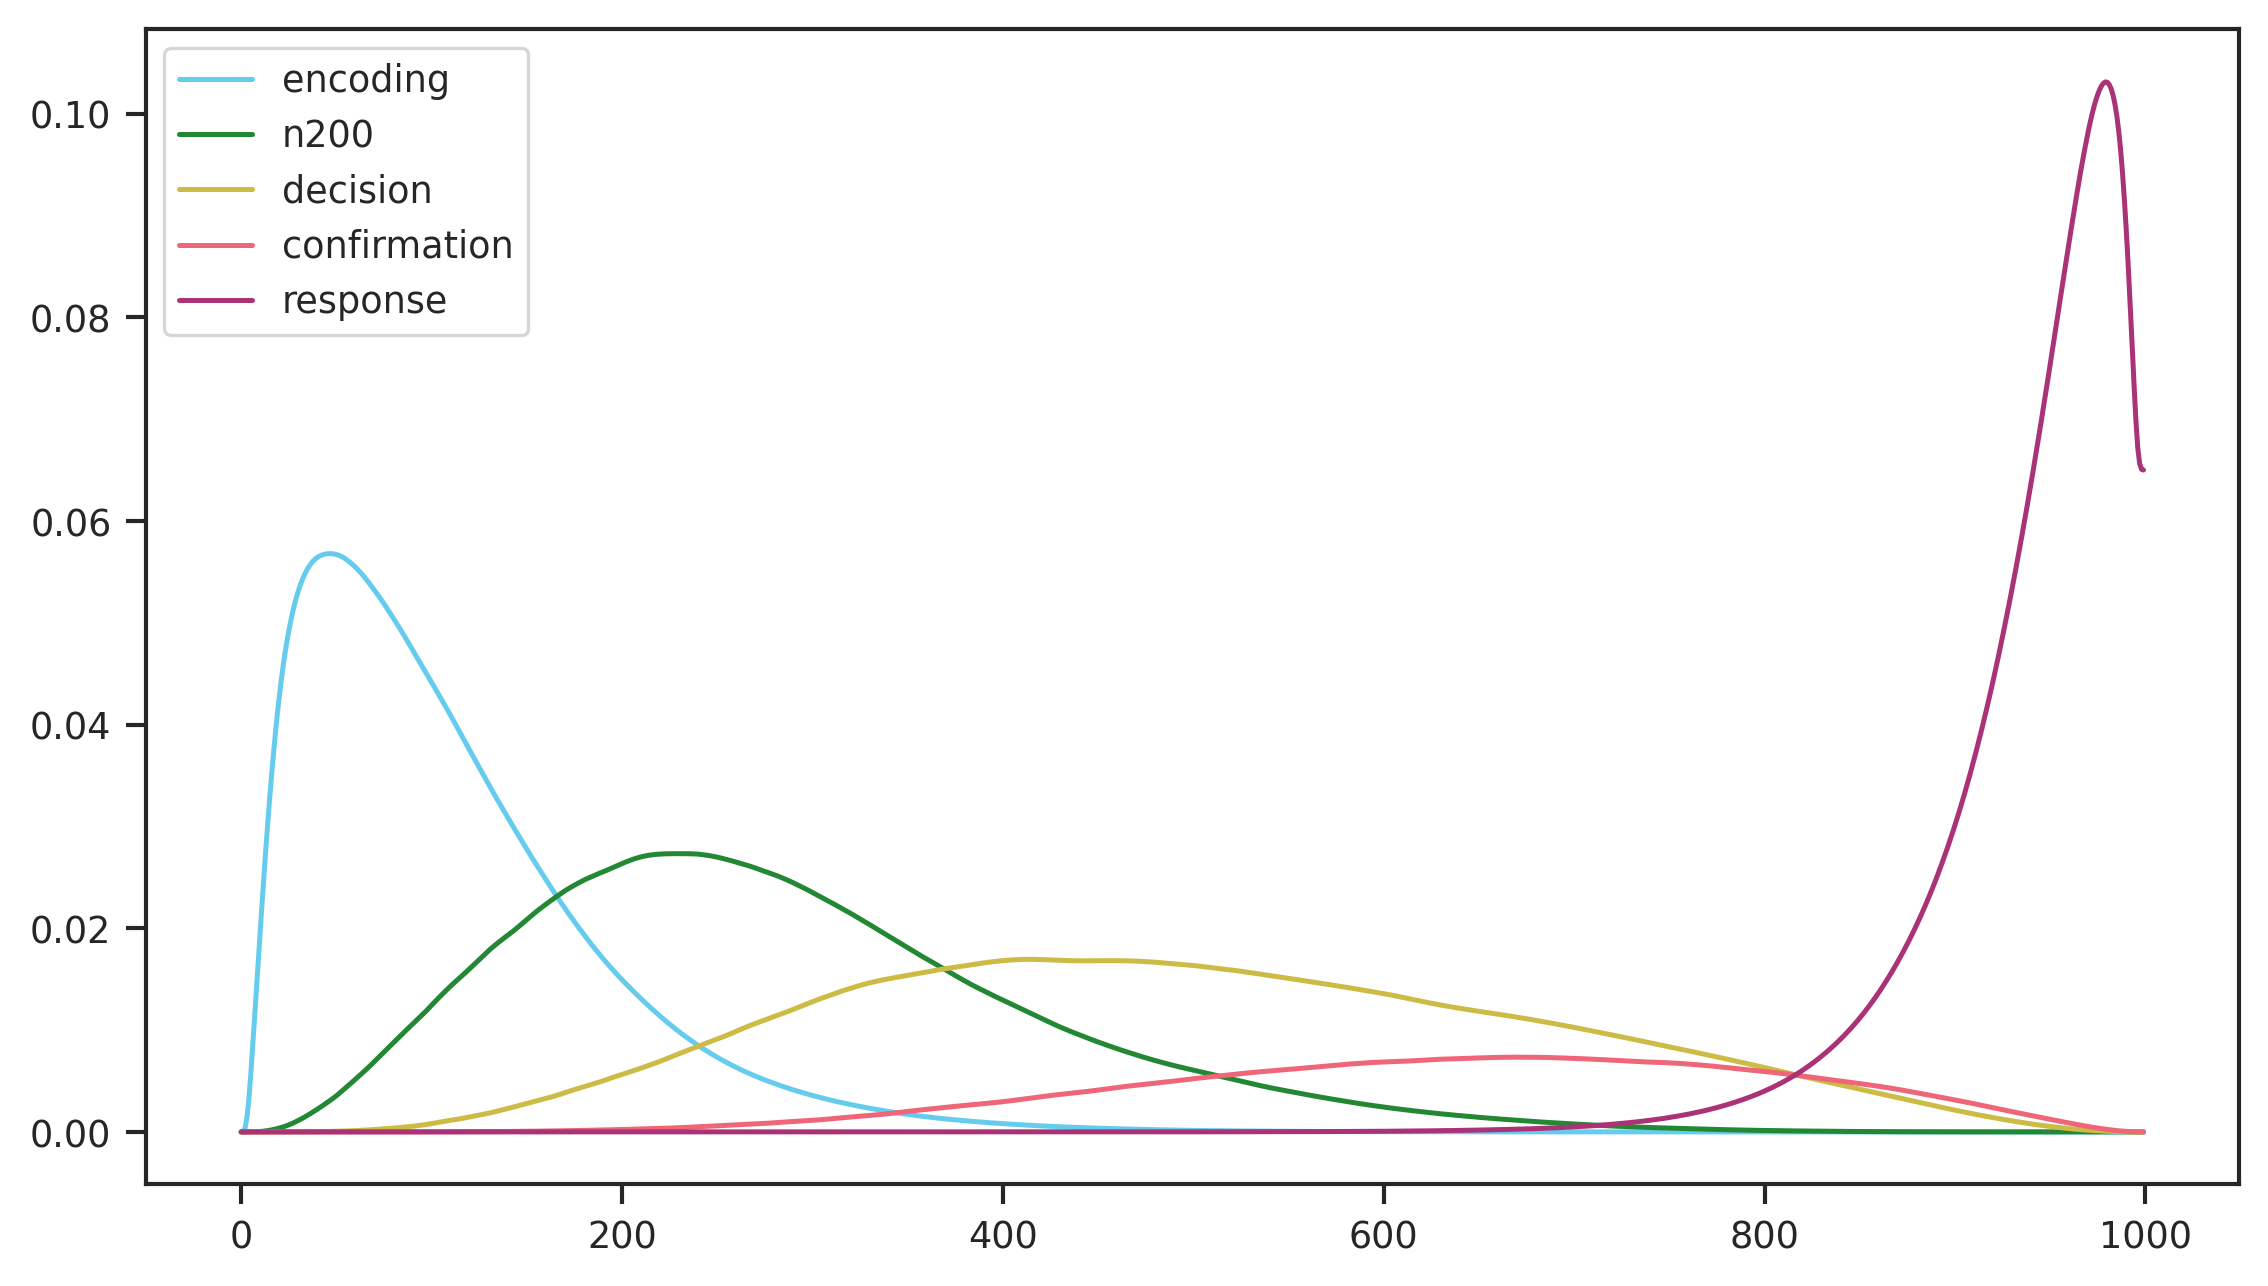

In [32]:
plot_density_hmp(loader)


In [1]:
import xarray as xr
import os
from pathlib import Path
DATA_PATH = Path(os.getenv("DATA_PATH"))
data_paths = [DATA_PATH / "sat2/stage_data_proba_250hz.nc"]

In [2]:
ds = xr.load_dataset(data_paths[0])

In [4]:
ds.probabilities.values.shape

(19, 2448, 6, 1049)

In [80]:
test_probas = ds.probabilities.values[0,0,:]

In [81]:
test_probas.shape

(6, 1049)

In [68]:
import numpy as np
mask = (test_probas != 0).any(axis=1)
# Use the non-zero indices to find the min and max for each sample

# Find minimum and maximum indices for each sample
first_nonzero = np.where(mask.any(axis=1), np.argmax(mask, axis=1), -1)
last_nonzero = np.where(mask.any(axis=1), mask.shape[-1] - 1 - np.argmax(mask[:, ::-1], axis=1), -1)

lowest_highest = np.stack((first_nonzero, last_nonzero), axis=1)


In [77]:
test_probas[0, :, 62]
test_probas[0, :, 178]
# STARTS AT LOWEST, ENDS AT HIGHEST, arange should have changed values in exactly these

array([0.0000000e+00, 0.0000000e+00, 2.6657462e-24, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

In [69]:
lowest_highest

array([[ 62, 178],
       [ 62, 163],
       [ 62, 172],
       [ 62, 172],
       [ 63, 172],
       [ 62, 179],
       [ 62, 189],
       [ 62, 172],
       [ 62, 165],
       [ 62, 187],
       [ 62, 172],
       [ 62, 191],
       [ -1,  -1],
       [ 62, 171],
       [ 62, 170],
       [ 62, 140],
       [ 62, 152],
       [ 62, 159],
       [ 62, 160],
       [ 63, 158],
       [ 62, 141],
       [ 62, 152],
       [ 62, 153],
       [ -1,  -1],
       [ 62, 159],
       [ 62, 162],
       [ 62, 161],
       [ 63, 179],
       [ 63, 218],
       [ 62, 189],
       [ 62, 166],
       [ -1,  -1]])

In [ ]:
(test_probas != 0).any(axis=0).nonzero()[0][0] + 1

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

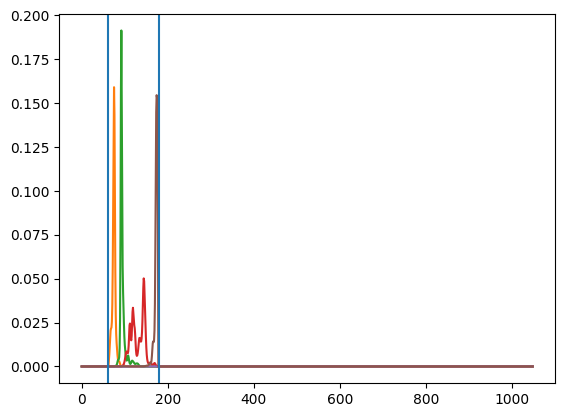

In [45]:
from matplotlib import pyplot as plt
plt.plot(test_probas.T)
plt.axvline(179)
plt.axvline(61)
plt.show()